In [12]:
import numpy as np
from numpy import pi,exp,sin,cos
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

In [13]:
## Define STDP and Phase coupling function
A_STDP = 0.03
s_STDP = 4
T_theta = 125 # theta oscillation period in ms
dp = lambda dt: dt*2*pi/T_theta # dt = xi - xj
omega = lambda dx: A_STDP * exp(s_STDP*cos(dx)) * sin(dx)
# derivative in respect to xi
domega = lambda dx: 2*pi/T_theta*A_STDP*exp(s_STDP*cos(dx)) * (cos(dx) - s_STDP * sin(dx)**2 )


In [14]:
## Create Memorys
N = 200 # number of neurons
M = 10 # number of memorys
k_prior = 0.5 # concentration parameter for prior distribution
k_cue0 = 16 # for initial cue distribution
v_noise = 1/8 # for cue noise accumulation, k_cue(t) = 1/( 1/k_cue0 + v_noise*t/T_theta )
xMemory = np.random.vonmises(0,k_prior,(N,M))
## Create Synapses
W = np.zeros((N,N))
for i in range(N):
    for j in range(i): # 0<=j<i
        for k in range(M):
            W[i,j] += omega(xMemory[i,k]-xMemory[j,k])
            W[j,i] += omega(xMemory[j,k]-xMemory[i,k])
sigma2_W = np.var(W.flatten())


In [16]:
## Define ODE
def mainode(t,x,N,W,sigma2_W,xTarget,xNoise,k_prior,k_cue0,v_noise,T_theta):
    # Additional parameters
    # N: #neurons
    # W: Synpatic weight W[i,j] is from j to i
    # sigma2_W: variance of W
    # x_tilde is the recall cue
    # Recalculate K_cue
    k_cue = 1/( 1/k_cue0 + v_noise*t/T_theta )
    x_tilde = xTarget + xNoise(t)
    # Calculate phase response H
    H = np.zeros(N)
    for i in range(N):
        dxi = x[i] - x # dxi[j] = x[i] - x[j]
        H[i] = np.dot( W[i,:], domega(dxi) ) # H[i] = \sum_j W_{ij} * domega(xi-xj)
    #
    dx_prior    = -k_prior * sin(x)
    dx_external = -k_cue * sin(x-x_tilde)
    dx_synapse  = H/sigma2_W
    dx = dx_prior + dx_external + dx_synapse
    return dx

In [20]:
## Create noise
class storedNoise:
    def __init__(self,dt,tf,k_cue0,v_noise):
        t = np.arange(0,tf,dt)
        nt = len(t)
        # first generate discrete noise
        xNoise_d = np.empty((nt,N))
        xNoise_d[0] = np.random.vonmises(0,k_cue0,N)
        for tt in range(nt-1):
            v = v_noise*dt/T_theta
            cumulative = np.random.normal(0,v,N)
            xNoise_d[tt+1] = xNoise_d[tt] + cumulative
        self._t = t
        self._xNoise_d = xNoise_d
        # then interpolate with cubic spline
        self._xNoise = [interp1d(t,xNoise_d[:,ii],'cubic') 
                                for ii in range(N)]
    def __call__(self,t):
        xNoise = np.empty(N)
        for ii in range(N):
            xNoise[ii] = self._xNoise[ii](t)
        return xNoise

    



In [21]:
## Solve ODE
# Initial Condintion
k = 0 # memory to recall
xTarget = xMemory[:,k]
x0 = xTarget.copy() # np.random.vonmises(0,k_prior,N)
xNoise = storedNoise(1,160*T_theta,k_cue0,v_noise)
# xNoise = np.random.vonmises(0,k_cue,N)
# x_tilde = xTarget + xNoise

# Define firing events
events = [lambda t,x,j=j: sin((x[j] - 2*pi*t/T_theta)/2) for j in range(N)]
# events[i] = 0 if and only if x[i] == 2*pi*t/T mod 2pi

# Integration
tf = T_theta
kwargs = {
    'N': N,
    'W': W,
    'k_prior': k_prior,
    'k_cue0': k_cue0,
    'v_noise': v_noise,
    'sigma2_W': sigma2_W,
    'xNoise': xNoise,
    'xTarget': xTarget,
    'T_theta': T_theta
}
sol = solve_ivp(lambda t,y: mainode(t,y,**kwargs),(0,tf),x0,events=events)
t   = sol.t; tNow = sol.t[-1]
x_t = sol.y; xNow = sol.y[:,-1]
t_fire = sol.t_events
x_fire = [np.mod(ts/T_theta,1)*2*pi for ts in t_fire]
print(sol.message)


The solver successfully reached the end of the integration interval.


Text(0, 0.5, 'time')

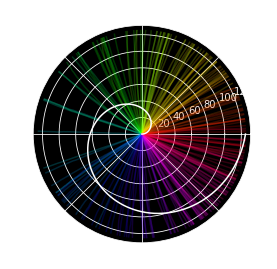

In [22]:
# show time course
from matplotlib.cm import get_cmap
hsv = get_cmap('hsv')
ax = plt.subplot(111,projection='polar')
for xi_t,target in zip(x_t,xTarget):
    color = hsv((target/pi/2)%1)
    ax.plot(xi_t,t,color=color,alpha=0.2)
ax.plot(2*pi*t/T_theta,t,color='white')
ax.set_ylabel('time')


Text(0, 0.5, 'counts')

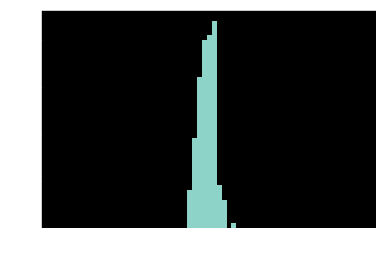

In [23]:
## evaluate errors
errors = x_t - np.transpose(np.tile(xTarget,(len(t),1)))
errors = np.mod(errors+pi,2*pi)-pi
h=plt.hist(errors[:,-1])
plt.xlim((-pi,pi))
plt.xlabel('error')
plt.ylabel('counts')


In [24]:
## Define STDP and Phase coupling function
A_STDP = 0.03
s_STDP = 4
T_theta = 125 # theta oscillation period in ms
dp = lambda dt: dt*2*pi/T_theta # dt = xi - xj
omega = lambda dx: A_STDP * exp(s_STDP*cos(dx)) * sin(dx)
# derivative in respect to xi
domega = lambda dx: 2*pi/T_theta*A_STDP*exp(s_STDP*cos(dx)) * (cos(dx) - s_STDP * sin(dx)**2 )
# other parameters
N = 200 # number of neurons
M = 10 # number of memorys
k_prior = 0.5 # concentration parameter for prior distribution
k_cue0 = 16 # for initial cue distribution

In [25]:
## Create Memorys
v_noise = 1/2 # for cue noise accumulation, k_cue(t) = 1/( 1/k_cue0 + v_noise*t/T_theta )
xMemory = np.random.vonmises(0,k_prior,(N,M))
## Create Synapses
W = np.zeros((N,N))
for i in range(N):
    for j in range(i): # 0<=j<i
        for k in range(M):
            W[i,j] += omega(xMemory[i,k]-xMemory[j,k])
            W[j,i] += omega(xMemory[j,k]-xMemory[i,k])
sigma2_W = np.var(W.flatten())


In [26]:
## Create noise
class storedNoise:
    def __init__(self,dt,tf,k_cue0,v_noise):
        t = np.arange(0,tf,dt)
        nt = len(t)
        # first generate discrete noise
        xNoise_d = np.empty((nt,N))
        xNoise_d[0] = np.random.vonmises(0,k_cue0,N)
        for tt in range(nt-1):
            v = v_noise*dt/T_theta
            cumulative = np.random.normal(0,v,N)
            xNoise_d[tt+1] = xNoise_d[tt] + cumulative
        self._t = t
        self._xNoise_d = xNoise_d
        # then interpolate with cubic spline
        self._xNoise = [interp1d(t,xNoise_d[:,ii],'cubic') 
                                for ii in range(N)]
    def __call__(self,t):
        '''
        storedNoise(t): xNoise at time t
        '''
        xNoise = np.empty(N)
        for ii in range(N):
            xNoise[ii] = self._xNoise[ii](t)
        return xNoise

    



In [27]:
## Define ODE
def mainode(t,x,N,W,sigma2_W,xTarget,xNoise,k_prior,k_cue0,v_noise,T_theta):
    # Additional parameters
    # N: #neurons
    # W: Synpatic weight W[i,j] is from j to i
    # sigma2_W: variance of W
    # x_tilde is the recall cue
    # Recalculate K_cue
    k_cue = 1/( 1/k_cue0 + v_noise*t/T_theta )
    x_tilde = xTarget + xNoise(t)
    # Calculate phase response H
    H = np.zeros(N)
    for i in range(N):
        dxi = x[i] - x # dxi[j] = x[i] - x[j]
        H[i] = np.dot( W[i,:], domega(dxi) ) # H[i] = \sum_j W_{ij} * domega(xi-xj)
    #
    dx_prior    = -k_prior * sin(x)
    dx_external = -k_cue * sin(x-x_tilde)
    dx_synapse  = H/sigma2_W
    dx = dx_prior + dx_external + dx_synapse
    return dx

In [28]:
## Solve ODE
# Initial Condintion
k = 0 # memory to recall
xTarget = xMemory[:,k]
xNoise = storedNoise(1,160*T_theta,k_cue0,v_noise)
x0 = xNoise(0) # np.random.vonmises(0,k_prior,N)

# Define firing events
events = [lambda t,x,j=j: sin((x[j] - 2*pi*t/T_theta)/2) for j in range(N)]
# events[i] = 0 if and only if x[i] == 2*pi*t/T mod 2pi

# Integration
tf = T_theta*2
kwargs = {
    'N': N,
    'W': W,
    'k_prior': k_prior,
    'k_cue0': k_cue0,
    'v_noise': v_noise,
    'sigma2_W': sigma2_W,
    'xNoise': xNoise,
    'xTarget': xTarget,
    'T_theta': T_theta
}
sol = solve_ivp(lambda t,y: mainode(t,y,**kwargs),(0,tf),x0,events=events)
t   = sol.t; tNow = sol.t[-1]
x_t = sol.y; xNow = sol.y[:,-1]
t_fire = sol.t_events
x_fire = [np.mod(ts/T_theta,1)*2*pi for ts in t_fire]
print(sol.message)


The solver successfully reached the end of the integration interval.


Text(0, 0.5, 'time')

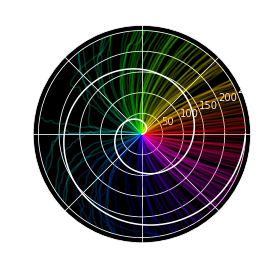

In [29]:
# show time course
from matplotlib.cm import get_cmap
hsv = get_cmap('hsv')
ax = plt.subplot(111,projection='polar')
for xi_t,target in zip(x_t,xTarget):
    color = hsv((target/pi/2)%1)
    ax.plot(xi_t,t,color=color,alpha=0.2)
ax.plot(2*pi*t/T_theta,t,color='white')
ax.set_ylabel('time')


Text(0, 0.5, 'counts')

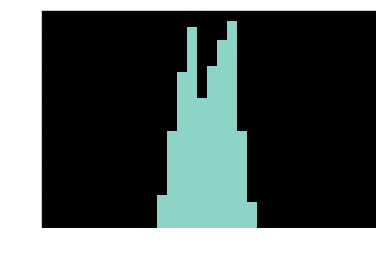

In [30]:
## evaluate errors
errors = x_t - np.transpose(np.tile(xTarget,(len(t),1)))
errors = np.mod(errors+pi,2*pi)-pi
h=plt.hist(errors[:,-1])
plt.xlim((-pi,pi))
plt.xlabel('error')
plt.ylabel('counts')


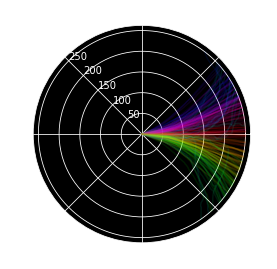

In [31]:
# show time course of error
ax = plt.subplot(projection='polar')
for dxi_t,target in zip(errors,xTarget):
    color = hsv((target/pi/2)%1)
    ax.plot(dxi_t,t,color=color,alpha=0.1)
ax.set_ylabel('time')
ax.set_rlabel_position(135)
